In [5]:
#import libraries
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import holidays
from sklearn import feature_selection as fs
import numpy.random as nr
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import metrics as m
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pickle
import shap

from numpy import array
#importing the different randoms
import os
import numpy.random as nr
import random as rn
import tensorflow as tf


nr.seed(24)

In [7]:
df=pd.read_csv("..\\Data\\half_hr_final.csv")

In [4]:
#os.getcwd()

'C:\\Users\\Vandana\\Documents\\GitHub\\Energy-Usage-Prediction-Project\\Vandana\\Individual_project_Capstone'

In [8]:
df

,timestamp,demand,temp,dew_point,humidity,wind_speed,pressure,condition
0,22/01/2017 0:00,1815.214,20.0,15.0,73,9,29,Fair
1,22/01/2017 0:30,1777.040,20.0,15.0,73,10,29,Fair
2,22/01/2017 1:00,1745.448,18.9,15.0,78,9,29,Fair
3,22/01/2017 1:30,1729.164,18.9,15.0,78,15,29,Fair
4,22/01/2017 2:00,1714.276,18.9,12.8,68,18,29,Fair
...,...,...,...,...,...,...,...,...
97499,15/08/2022 5:30,2078.318,23.9,15.0,57,13,29,Fair
97500,15/08/2022 6:00,2265.182,23.9,15.0,57,13,29,Fair
97501,15/08/2022 6:30,2399.786,23.9,15.0,57,13,29,Fair
97502,15/08/2022 7:00,2575.118,23.9,15.0,57,13,29,Fair


In [4]:



df.rename(columns={"timestamp" : 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M',infer_datetime_format=True).dt.strftime('%Y-%m-%d %H:%M')


### Data Structure

In [5]:
df.shape

(97504, 8)

In [6]:
#creating a separate data for weekly and monthly analysis
df1 = df.copy()

df1['Date'] = pd.to_datetime(df1['Date'], format="%Y-%m-%d %H")

df1 = df1.interpolate(method='bfill')
df1 = df1.interpolate(method='ffill')

In [7]:
df1

,Date,demand,temp,dew_point,humidity,wind_speed,pressure,condition
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73,9,29,Fair
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73,10,29,Fair
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78,9,29,Fair
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78,15,29,Fair
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68,18,29,Fair
...,...,...,...,...,...,...,...,...
97499,2022-08-15 05:30:00,2078.318,23.9,15.0,57,13,29,Fair
97500,2022-08-15 06:00:00,2265.182,23.9,15.0,57,13,29,Fair
97501,2022-08-15 06:30:00,2399.786,23.9,15.0,57,13,29,Fair
97502,2022-08-15 07:00:00,2575.118,23.9,15.0,57,13,29,Fair


<AxesSubplot:>

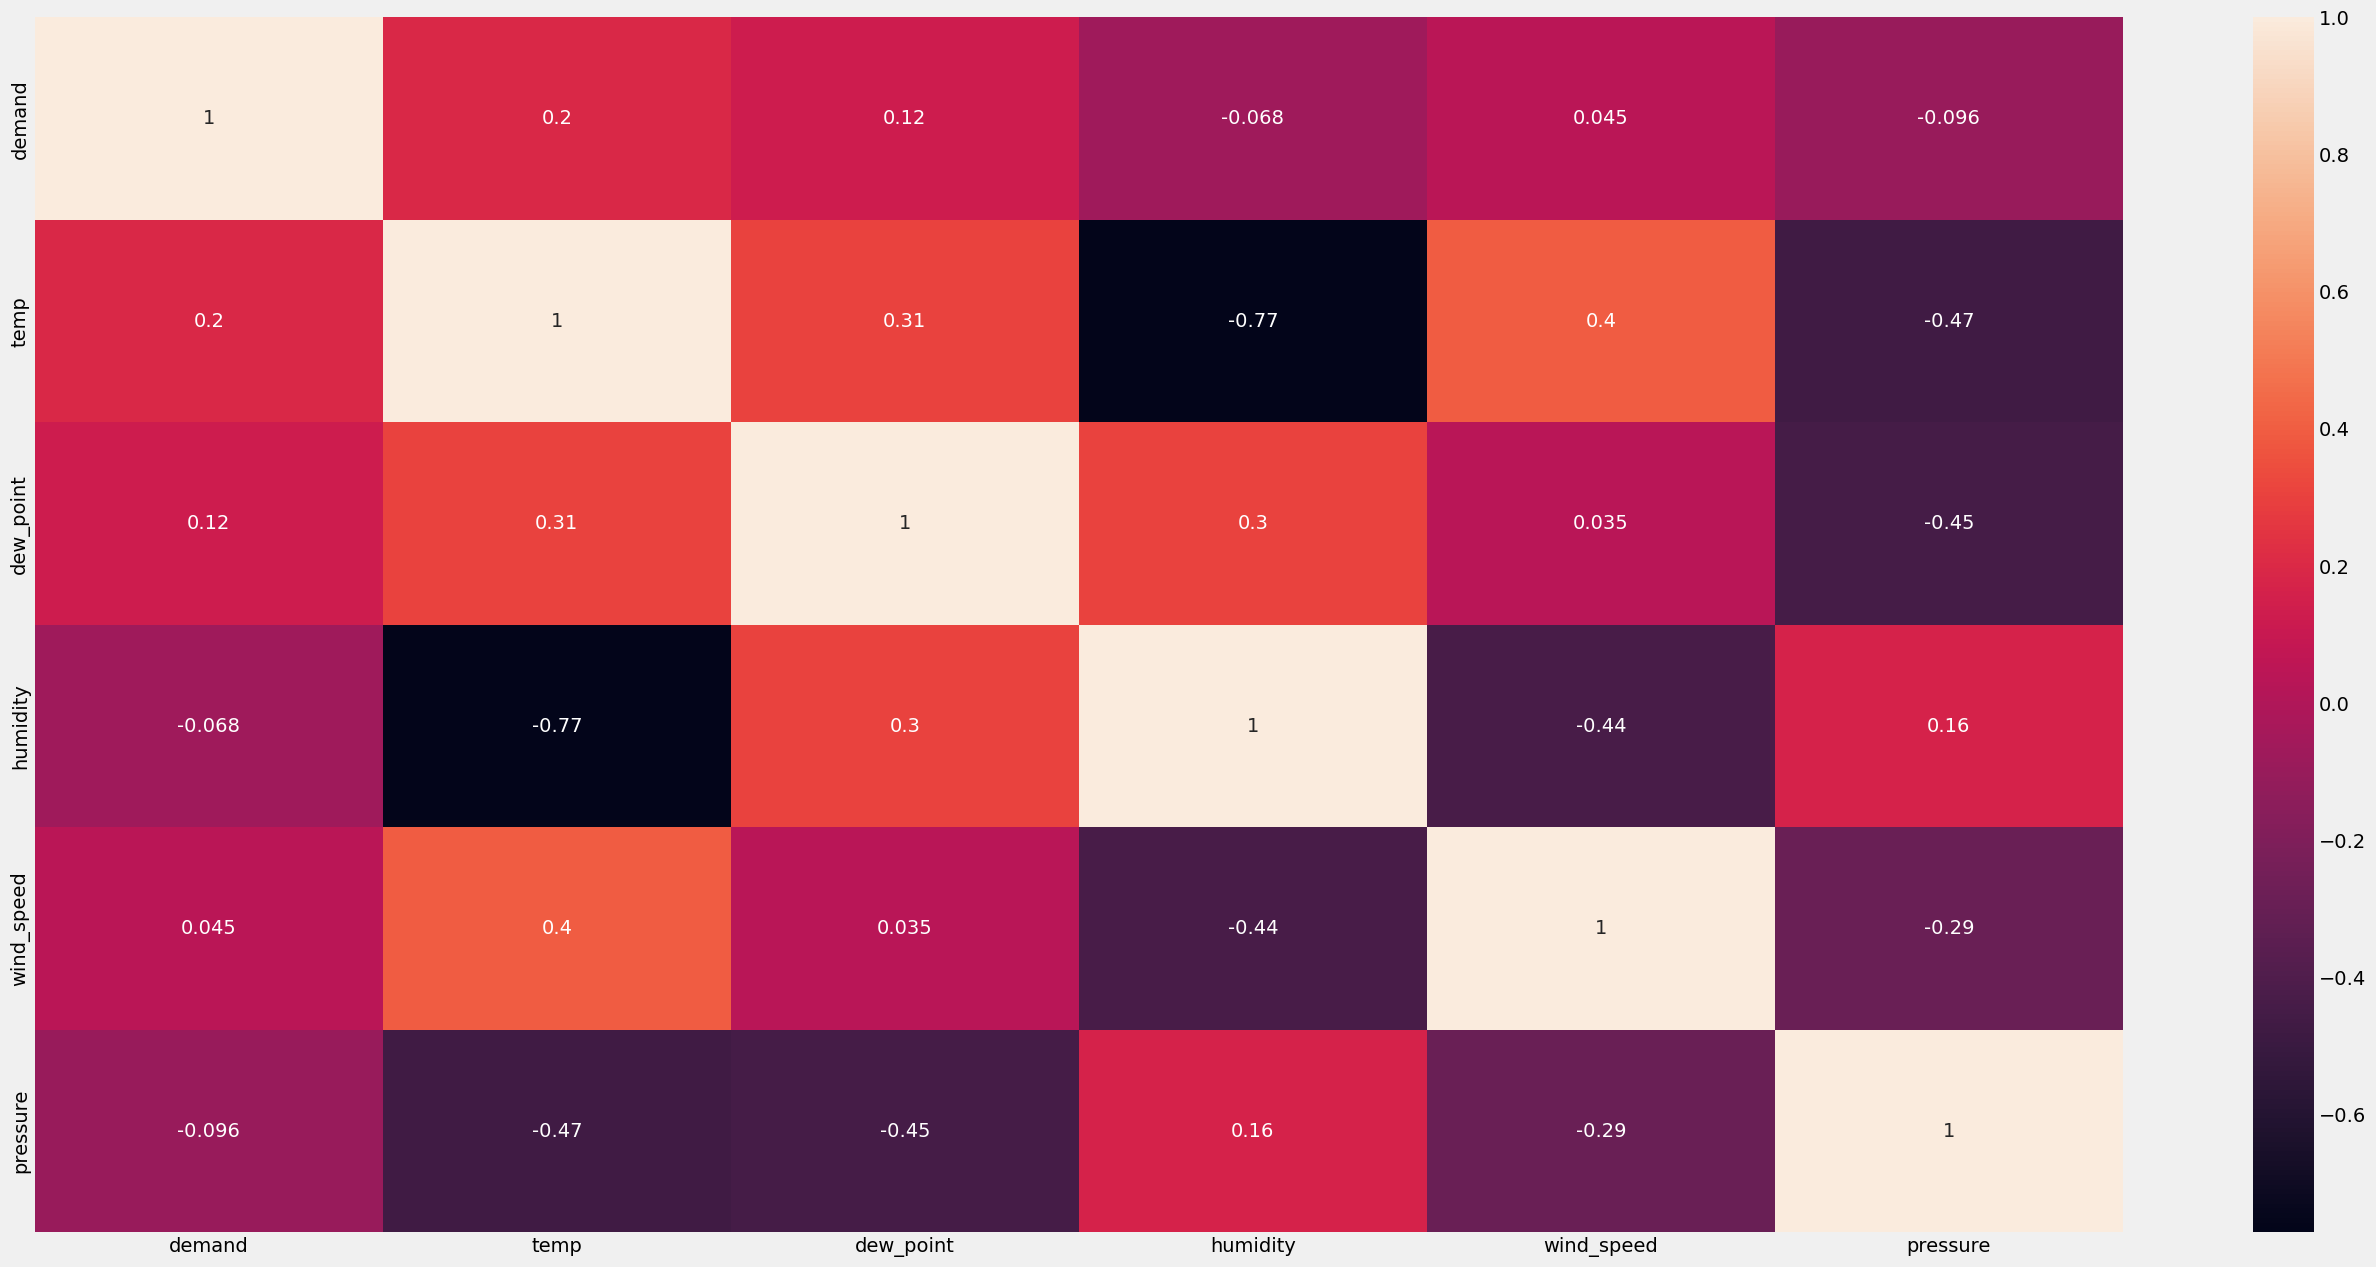

In [8]:
plt.figure(figsize=(30,15))
sns.heatmap(df1.corr(), annot=True)

As we can see temp has highest correlation with demand which is 0.23 only. Lets try to explore the Date features like hour, day, week of the yaer, is working day and holiday to see how it affect the demand.

# Defining Used Function

In [9]:
df1['hour'] = df1['Date'].dt.hour
df1['day'] = df1['Date'].dt.dayofyear
df1['week'] = df1['Date'].dt.week
df1['month'] = df1['Date'].dt.month
df1['weekday'] = df1['Date'].dt.day_name()

#dictionary for useful variables
#Aus's Holidays
AU_holidays = holidays.AUS()
df1['holiday'] = [1 if d in AU_holidays else 0 for d in df1['Date']]
df1[df1['holiday'] == 1]

df1['isWorkDay'] = df1.apply(lambda x: 'no' if ((x['holiday'] == 1) or
                                          (x['weekday'] in ['Sunday', 'Saturday'])) else 'yes', axis=1)

cat_cols = ['hour','day','week','month','weekday','holiday','isWorkDay','condition']
for col in cat_cols:
  df1[col] = df1[col].astype('category')

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97504 entries, 0 to 97503
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        97504 non-null  datetime64[ns]
 1   demand      97504 non-null  float64       
 2   temp        97504 non-null  float64       
 3   dew_point   97504 non-null  float64       
 4   humidity    97504 non-null  int64         
 5   wind_speed  97504 non-null  int64         
 6   pressure    97504 non-null  int64         
 7   condition   97504 non-null  category      
 8   hour        97504 non-null  category      
 9   day         97504 non-null  category      
 10  week        97504 non-null  category      
 11  month       97504 non-null  category      
 12  weekday     97504 non-null  category      
 13  holiday     97504 non-null  category      
 14  isWorkDay   97504 non-null  category      
dtypes: category(8), datetime64[ns](1), float64(3), int64(3)
memory usage: 

In [11]:
#creating merics to measure model performance
def metric(y_pred, y_actual, model_name = None):

  print('\nError metrics for {}'.format(model_name))

  R2 = m.r2_score(y_pred, y_actual)
  print('R2 Score: %.2f' % R2)

  MSE = m.mean_squared_error(y_pred, y_actual)
  print('Mean Squared Error: %.2f' % MSE)

  RMSE = sqrt(MSE)
  print('\nRoot Mean Squared Error: %.2f' % RMSE)

  MAE = m.mean_absolute_error(y_pred, y_actual)
  print('Mean Absolute Error: %.2f' % MAE)

  MAPE = m.mean_absolute_percentage_error(y_pred, y_actual)
  print('Mean Absolute Percentage Error: %.4f' % MAPE)

def plot_pred_vs_actual(y_pred, y_actual, model_name=None):
  fig, ax = plt.subplots(1,1, figsize=(15,10))
  ax.scatter(y_pred, y_actual)
  _ = plt.xlabel('Actual Demand [mW]')
  _ = plt.ylabel('Predicted Demand [mW]')
  _ = plt.title('Actual Vs Predicted Demand [mW] for {} model'.format(model_name))
  _ = plt.xlim(700, 5000)
  _ = plt.ylim(700, 5000)
  X = np.linspace(*ax.get_xlim())
  _ = ax.plot(X,X)
def coef_plot(val, model, model_name = None):
  _ = plt.figure(figsize=(15,10))
  _ = plt.plot(range(len(val.columns)), model.coef_)
  _ = plt.xticks(range(len(val.columns)), val.columns, rotation = 90)
  _ = plt.margins(0.01)
  _ = plt.axhline(0, linewidth = 0.5, color = 'r')
  _ = plt.xlabel('{} coef'.format(model_name))
  _ = plt.ylabel('features')
  _ = plt.title("Coefficients of {}'s Features". format(model_name))


def split_data(data, test_size = 0.15, col_to_trans = None, scale = False, include_entire_data = False):
  # get train index
  train_index = int(len(data)*(1 - (test_size)))
  samp_data = data.copy()
  if scale and include_entire_data:
    scaler = StandardScaler()
    samp_data[col_to_trans] = scaler.fit_transform(samp_data[col_to_trans])

  X_train = samp_data.drop('demand', axis=1).iloc[:train_index]
  X_test = samp_data.drop('demand', axis =1).iloc[train_index:]
  y_train = samp_data.demand.iloc[:train_index]
  y_test = samp_data.demand.iloc[train_index:]

  if scale and not include_entire_data:
    scaler = StandardScaler()
    X_train[col_to_trans] = scaler.fit_transform(X_train[col_to_trans])
    X_test[col_to_trans] = scaler.transform(X_test[col_to_trans])

  return X_train, X_test, y_train, y_test


In [12]:
df1["date"] = pd.to_datetime(df1['Date']).dt.date
df1['date'] = pd.to_datetime(df1['date'])
start_date = '2017-01-22'
end_date = '2022-03-31'
# Select DataFrame rows between two dates
mask = (df1['date'] >=start_date) & (df1['date'] <= end_date)
df2 = df1.loc[mask]


In [13]:
df2

,Date,demand,temp,dew_point,humidity,wind_speed,pressure,condition,hour,day,week,month,weekday,holiday,isWorkDay,date
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73,9,29,Fair,0,22,3,1,Sunday,0,no,2017-01-22
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73,10,29,Fair,0,22,3,1,Sunday,0,no,2017-01-22
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78,9,29,Fair,1,22,3,1,Sunday,0,no,2017-01-22
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78,15,29,Fair,1,22,3,1,Sunday,0,no,2017-01-22
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68,18,29,Fair,2,22,3,1,Sunday,0,no,2017-01-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90955,2022-03-31 21:30:00,2496.326,23.9,15.0,57,13,29,Fair,21,90,13,3,Thursday,0,yes,2022-03-31
90956,2022-03-31 22:00:00,2418.866,23.9,15.0,57,13,29,Fair,22,90,13,3,Thursday,0,yes,2022-03-31
90957,2022-03-31 22:30:00,2323.210,23.9,15.0,57,13,29,Fair,22,90,13,3,Thursday,0,yes,2022-03-31
90958,2022-03-31 23:00:00,2245.612,23.9,15.0,57,13,29,Fair,23,90,13,3,Thursday,0,yes,2022-03-31


We will try the baseline linear regression model to see how it works with our dataset.

# Model Design- Ordinary least squares

In [14]:
model = ols('demand ~ C(month) + C(hour) + C(condition) + C(holiday) + C(isWorkDay) \
            + C(week) + temp + wind_speed + humidity + dew_point + pressure\
                + C(day)+C(week)', df2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     381.1
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        08:04:27   Log-Likelihood:            -6.2285e+05
No. Observations:               90960   AIC:                         1.247e+06
Df Residuals:                   90458   BIC:                         1.251e+06
Df Model:                         501                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [15]:
model1 = ols('demand ~ C(month) + C(hour) +  C(holiday) + C(isWorkDay) \
            + C(week) + temp + humidity + dew_point + pressure\
                +C(week)', df2).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     1878.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        08:04:29   Log-Likelihood:            -6.2602e+05
No. Observations:               90960   AIC:                         1.252e+06
Df Residuals:                   90867   BIC:                         1.253e+06
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             823.5411    

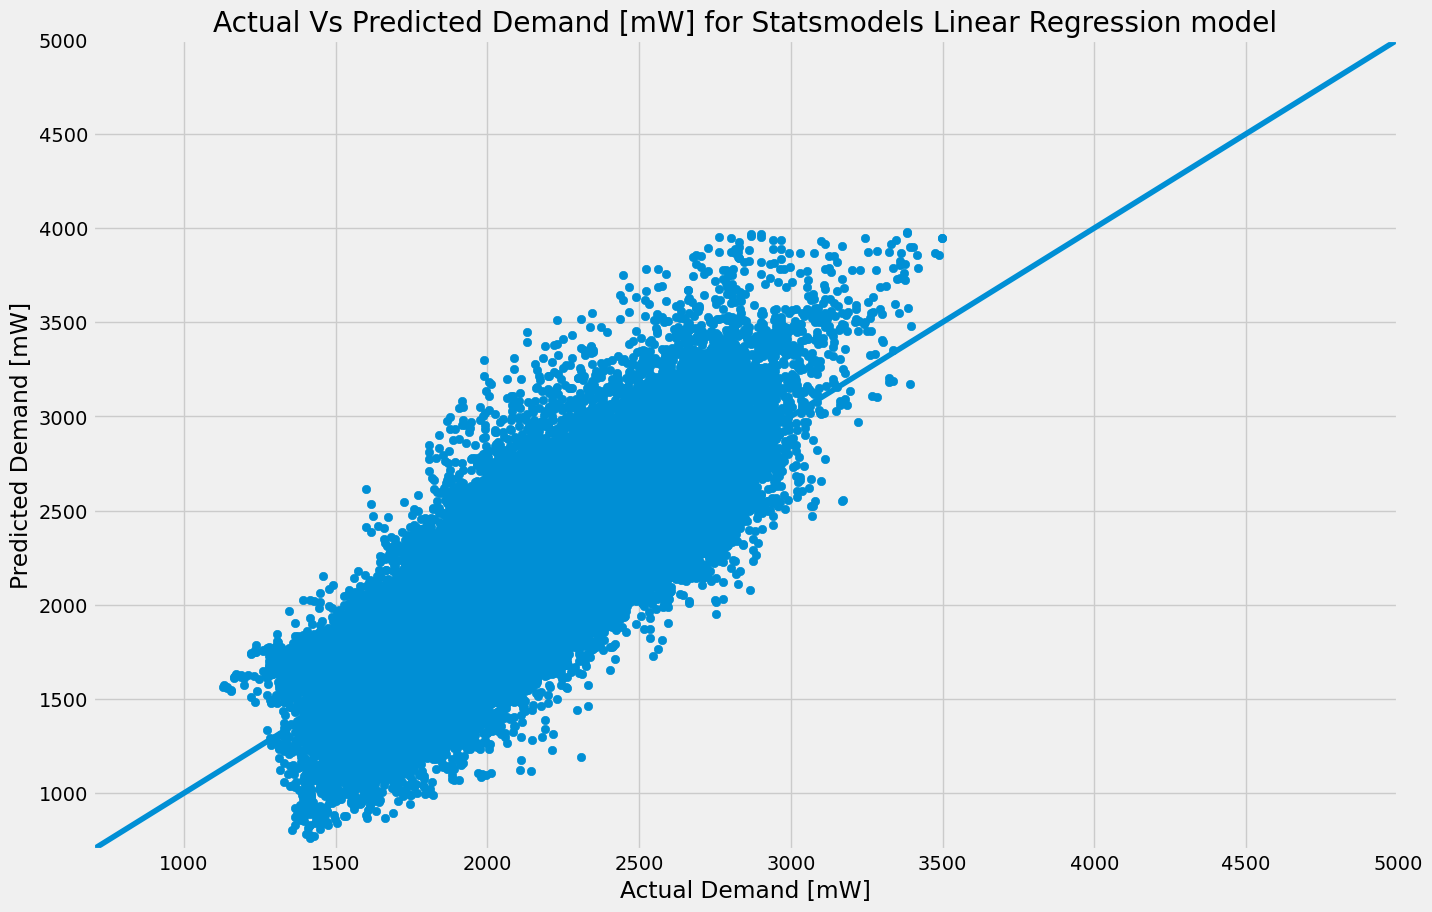

In [16]:
plot_pred_vs_actual(model.fittedvalues, df2.demand, model_name = 'Statsmodels Linear Regression')

In [17]:
used_cols = ['Date','demand','month','hour','holiday','isWorkDay','week']

In [18]:
sk_df = pd.get_dummies(df2[used_cols], drop_first=True)
sk_df = sk_df.set_index('Date')
sk_df

,demand,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-22 00:00:00,1815.214,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-22 00:30:00,1777.040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-22 01:00:00,1745.448,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-22 01:30:00,1729.164,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-22 02:00:00,1714.276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 21:30:00,2496.326,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-31 22:00:00,2418.866,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-31 22:30:00,2323.210,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_train, X_test, y_train, y_test = split_data(sk_df, test_size=0.15, include_entire_data=False)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

metric(lr.predict(X_train), y_train, 'Sklearn Linear Regression training data')
metric(pred, y_test, 'Sklearn Linear Regression test data')


Error metrics for Sklearn Linear Regression training data
R2 Score: 0.38
Mean Squared Error: 54437.24

Root Mean Squared Error: 233.32
Mean Absolute Error: 172.78
Mean Absolute Percentage Error: 0.0859

Error metrics for Sklearn Linear Regression test data
R2 Score: -0.48
Mean Squared Error: 132864.22

Root Mean Squared Error: 364.51
Mean Absolute Error: 268.46
Mean Absolute Percentage Error: 0.1336


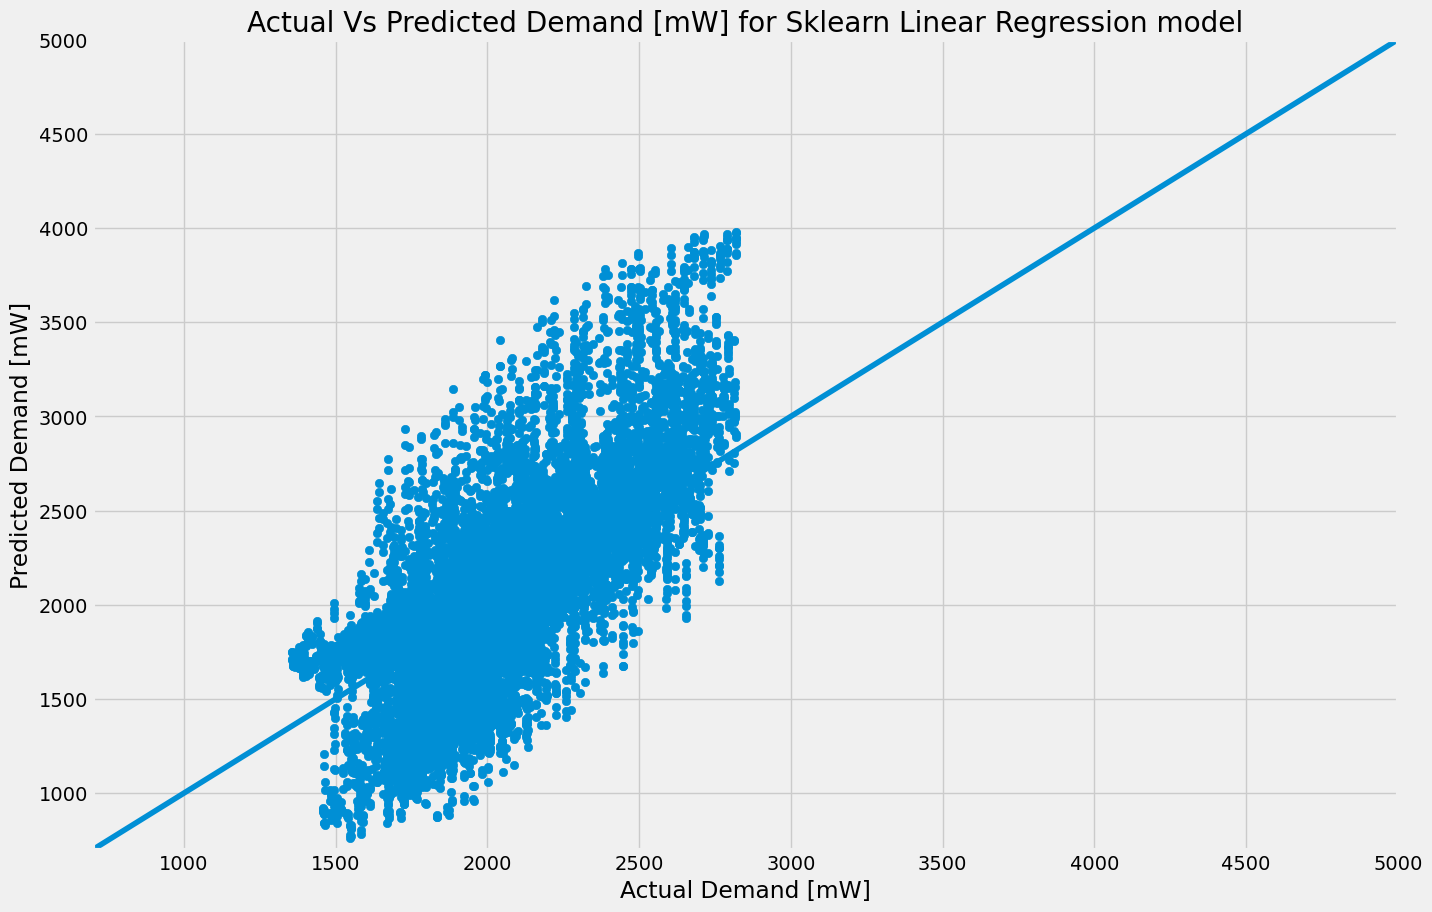

In [20]:
plot_pred_vs_actual(pred, y_test,model_name='Sklearn Linear Regression')

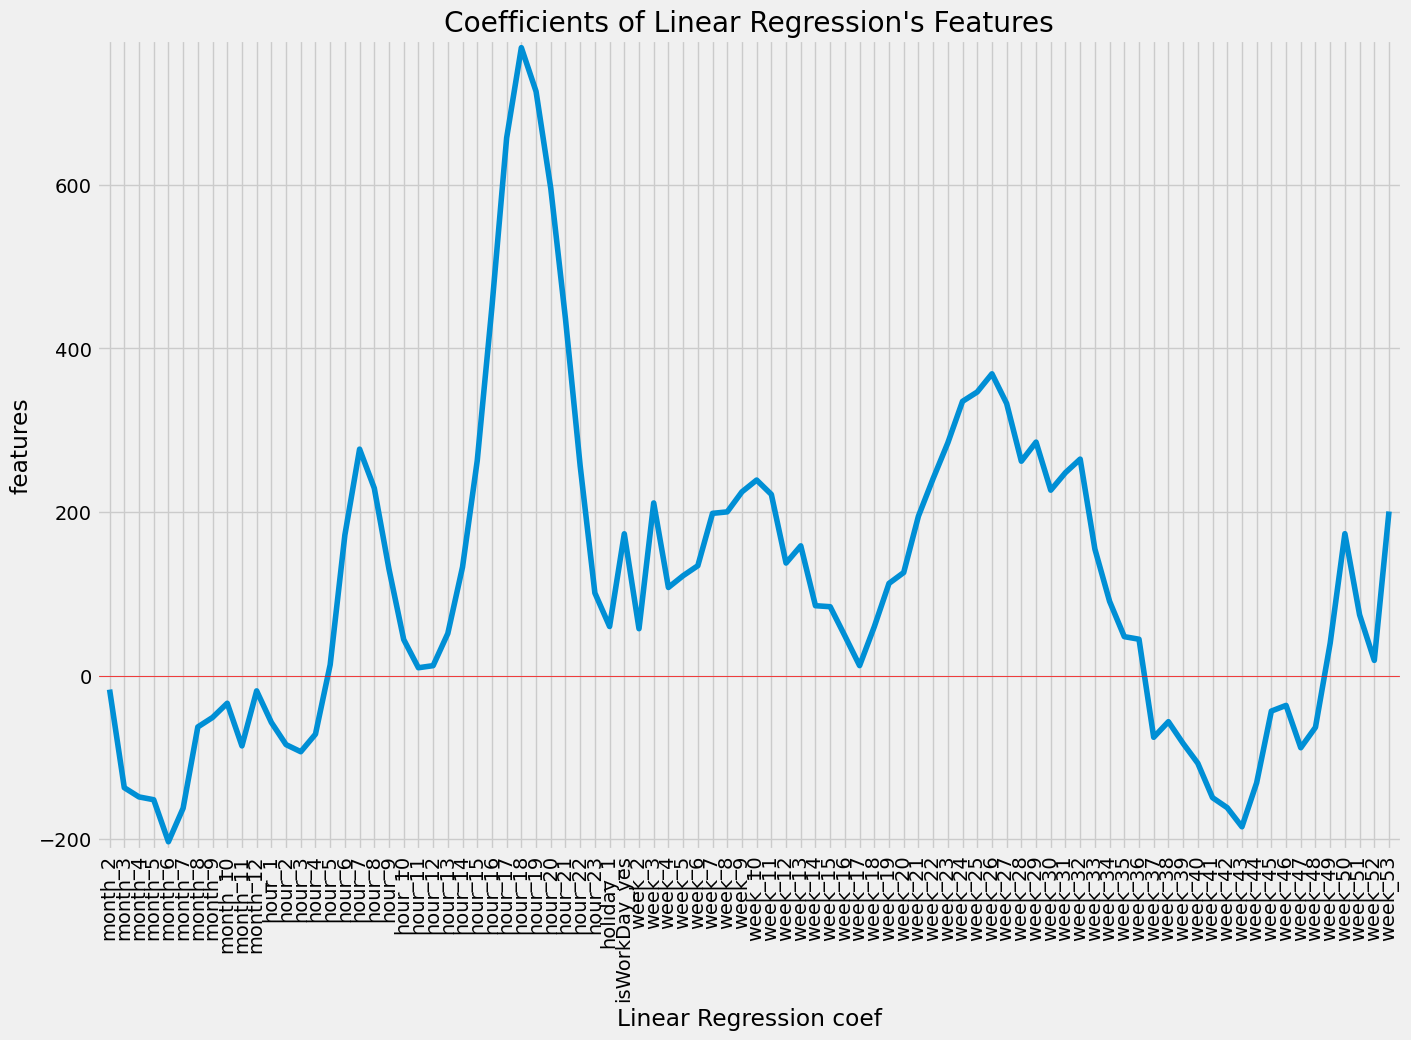

In [21]:
coef_plot(X_train, lr, 'Linear Regression')

We can see OLS model is not performing well. We will check our model against Persistent model. We can check for a year ago model, a week model and an hour model.

# Persistent(Repeat values from one year ago) model

In [22]:
naive_pred = sk_df.loc[X_test.index.shift(-17520, freq='30min'),'demand']
metric(naive_pred[0:], y_test, 'Naive or Persistent model')  #leap year


Error metrics for Naive or Persistent model
R2 Score: 0.28
Mean Squared Error: 132740.34

Root Mean Squared Error: 364.34
Mean Absolute Error: 252.67
Mean Absolute Percentage Error: 0.1306


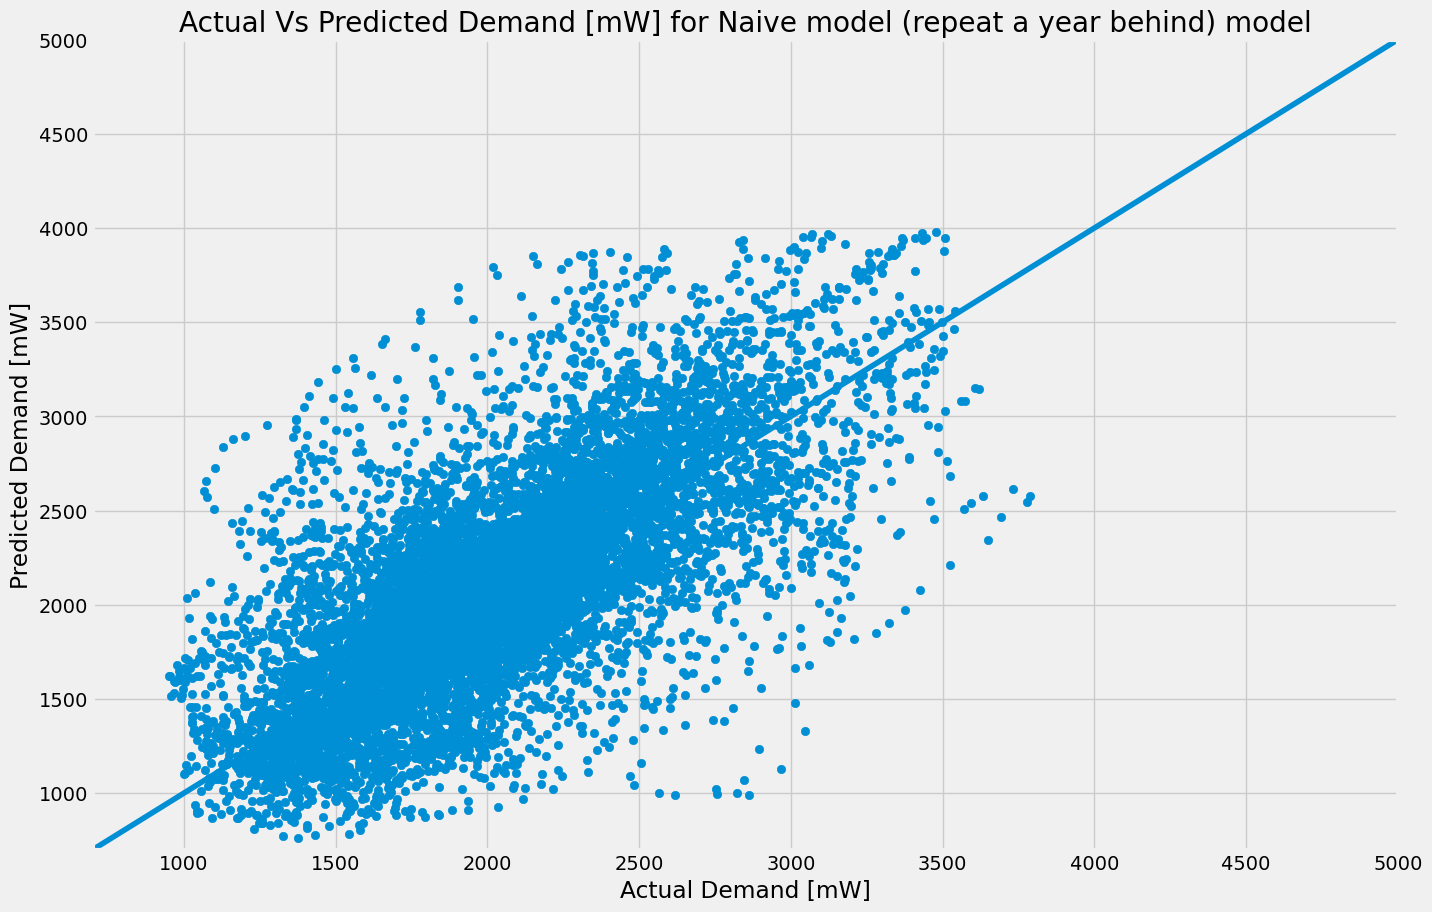

In [23]:
plot_pred_vs_actual(naive_pred[0:], y_test,model_name='Naive model (repeat a year behind)')

## Persistent (Repeat last hour) model

In [24]:
# one hour ahead for cast
naive_pred2 = sk_df.loc[X_test.index.shift(-2, freq='30min'), 'demand']
metric(naive_pred2[0:], y_test, 'last hour naive forcast')


Error metrics for last hour naive forcast
R2 Score: 0.89
Mean Squared Error: 29637.76

Root Mean Squared Error: 172.16
Mean Absolute Error: 136.52
Mean Absolute Percentage Error: 0.0680


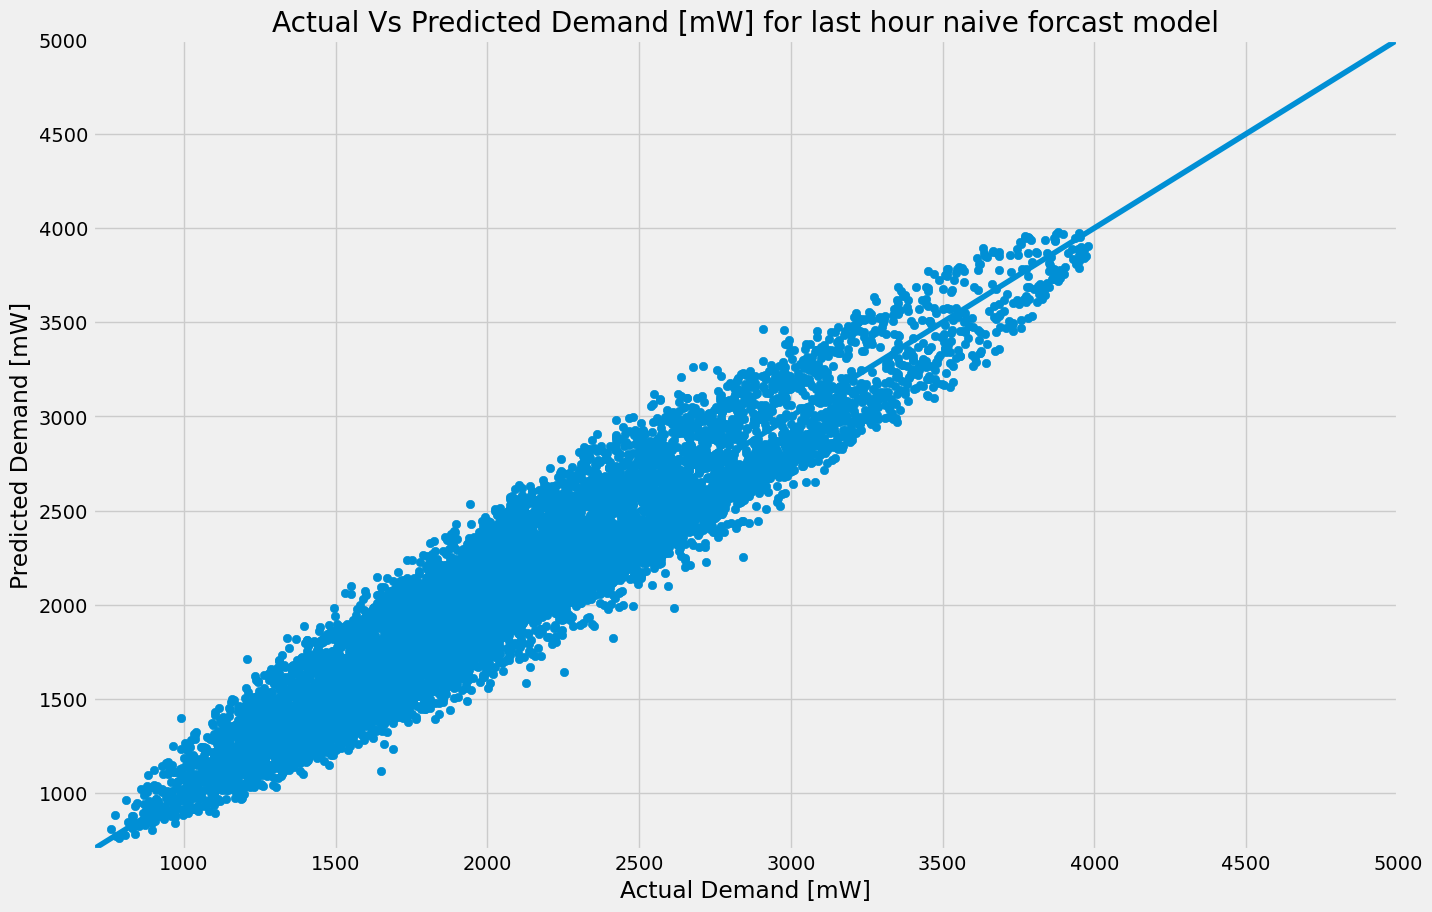

In [25]:
plot_pred_vs_actual(naive_pred2[0:], y_test, model_name='last hour naive forcast')

## Persistent (Repeat last one week) model

In [26]:
# one week ahead for cast
naive_pred3 = sk_df.loc[X_test.index.shift(-336, freq='30min'), 'demand']
metric(naive_pred3[0:], y_test, 'last week naive forcast')


Error metrics for last week naive forcast
R2 Score: 0.36
Mean Squared Error: 175179.30

Root Mean Squared Error: 418.54
Mean Absolute Error: 276.96
Mean Absolute Percentage Error: 0.1387


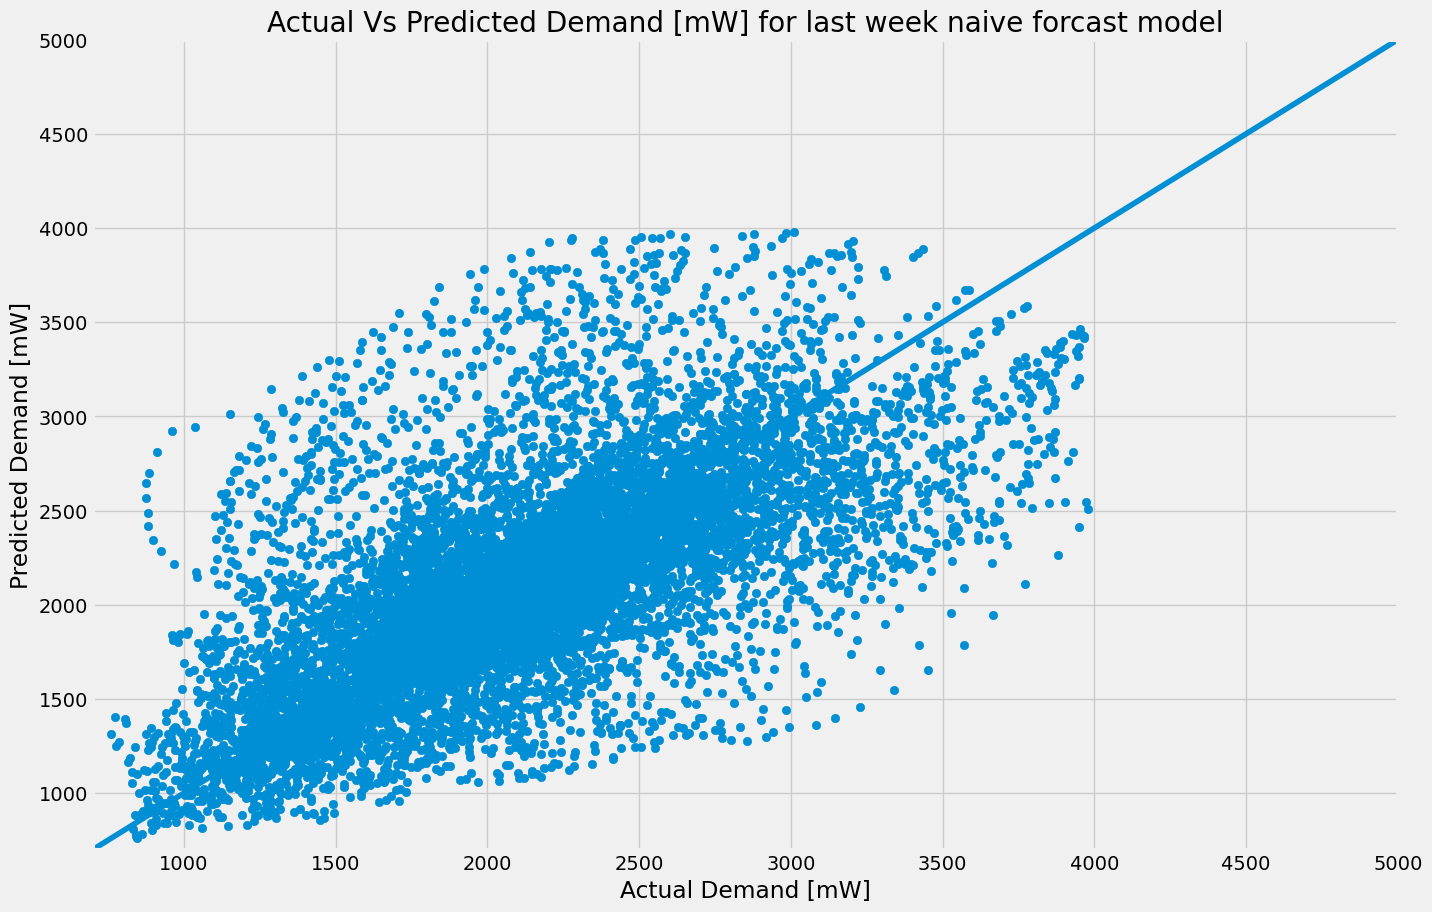

In [27]:
plot_pred_vs_actual(naive_pred3[0:], y_test, model_name='last week naive forcast')

We can see that one hour model is better than others with MAPE of 6.81.

As we can see temprature and other weather data has less affect on demand, also to keep our model simle and explainable, I will use only Date's feature in the model. This will also remove our depencence on weather data. As BOM forecast are not available in 1 hr or 30 min format for next 7 days, we will be restricted to use our model to limited prediction. To avoid all these pitfall we will try only demand and date data which is also available on AEMO website. Lets see how it works

# Adding 24 hours Lag

In [28]:
#with and without wind speed has been tried, the latter was the optimal
cols_used = ['Date','demand', 'holiday','isWorkDay','week','hour','month']
lag_df = df2[cols_used].set_index('Date')
lag_df['isWorkDay'] = [0 if t == 'no' else 1 for t in lag_df['isWorkDay']]

In [29]:
# getting 24 hours lag -48 obs
for i in range(48):
  lag_df['lag' + str(i+1)] = lag_df['demand'].shift(i+1)
#drop the first 24 hours NaN values
lag = lag_df.dropna()

In [30]:
lags_list = ['lag' + str(i+1) for i in range(48)]
#cols_to_trans.extend(lags_list)
X_train, X_test, y_train, y_test = split_data(lag,test_size=0.15,                                              
                                              include_entire_data=False)

#  Analysis

In [31]:
min, max = lag.index.min(), lag.index.max()
data = lag.copy()
data['Date'] = pd.date_range(start = min, end = max, freq='30min')
demand_data = data[['demand']]

def decopose_df(df):
  decompose = seasonal_decompose(df)
  fig = decompose.plot()
  fig.set_size_inches(25,12)
  fig.tight_layout()
  plt.show()

def metricf(fcast, test):
  mae = m.mean_absolute_error(test,fcast)
  print('MAE : %3f' % mae)
  mse = m.mean_squared_error(test,fcast)
  print('MSE : %3f' % mse)
  rmse = sqrt(mse)
  print('RMSE : %3f' % rmse)
  mape = m.mean_absolute_percentage_error(test,fcast)
  print('MAPE : %3f' % mape)


def split_data_fcast(X,y):
  X_train, X_test, y_train, y_test = X[:-5713], X[-5713:], y[:-5713], y[-5713:]
  return X_train, X_test, y_train, y_test


def split_sequence_mult(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ts = i + n_steps_in
    out_ts = end_ts + n_steps_out -1 
    if out_ts > len(sequence):
      break;
    seqx, seqy = sequence.iloc[i:end_ts, 1:], sequence.iloc[end_ts-1:out_ts, 0]
    X.append(seqx)
    y.append(seqy)
  return array(X), array(y)

def plot_result(yhat, test, model_name = None):
  pred = array([i for i in yhat]).reshape(-1,1)
  tester = array([i for i in test]).reshape(-1,1)
  pred = pd.DataFrame(pred)
  tester = pd.DataFrame(tester)
  result = pd.concat([pred, tester],ignore_index=True, axis=1)
  plt.figure(figsize=(25,18))
  plt.plot(result[0], color = 'blue', label="Forecasted Demand")
  plt.plot(result[1],color = 'green', label="Actual Demand")
  plt.legend(loc='upper left')
  plt.title('Forecasted and Actual Demand of {}'.format(model_name))
  plt.xlabel('Hours')
  plt.ylabel('Demand')
  print('Accuracy: {}'.format(m.r2_score(pred, tester)))

In [32]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
def confusion_matrix_cal(threshold):    
    predicted_class1=np.zeros(df_merged["Prediction"].shape)
    predicted_class1[df_merged["Prediction"]>threshold]=1
    actual_class1=np.zeros(df_merged["Actual"].shape)
    actual_class1[df_merged["Actual"]>threshold]=1
    actual=pd.DataFrame(actual_class1)
    cm1 = confusion_matrix(actual,predicted_class1)
    print('Confusion Matrix : \n', cm1)
    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)
    

# Calculation for Threshold

In [33]:
#df2["date"] = pd.to_datetime(df1['Date']).dt.date
#df2['date'] = pd.to_datetime(df1['date'])
start_date = '2020-12-01'
end_date = '2021-03-31'
# Select DataFrame rows between two dates
mask = (df2['date'] >=start_date) & (df2['date'] <= end_date)
df3 = df2.loc[mask]


In [34]:
summer_demand_daily = pd.DataFrame(df3.groupby(['date'])["demand"].sum().reset_index())
#summer_demand_daily
q=pd.DataFrame(summer_demand_daily.sort_values(by=['demand']).tail(4).reset_index())
q['date'] = pd.to_datetime(q['date'])
threshold=np.percentile(q['demand'], 95)
threshold


133912.9754

## 48 hours ahead forecast

### MLP model (96-in, 96 out)

In [35]:
new_lag =  lag
lags_list = ['lag' + str(i+1) for i in range(96)]
scaler = StandardScaler()

In [36]:
n_steps_in, n_steps_out = 96,96
X, y = split_sequence_mult(new_lag, n_steps_in=n_steps_in,n_steps_out=n_steps_out)
#flatten inputs
n_inputs, n_out = X.shape[1] * X.shape[2], 96
XM = X.reshape(X.shape[0], n_inputs)
X_train, X_test, y_train, y_test = XM[:-5713], XM[-5713:], y[:-5713], y[-5713:]

In [37]:
y_test

array([[1788.716, 1768.478, 1756.662, ..., 1973.264, 1909.09 , 1861.354],
       [1768.478, 1756.662, 1735.248, ..., 1909.09 , 1861.354, 1821.268],
       [1756.662, 1735.248, 1724.418, ..., 1861.354, 1821.268, 1783.518],
       ...,
       [2080.15 , 2015.012, 1971.456, ..., 2496.326, 2418.866, 2323.21 ],
       [2015.012, 1971.456, 1923.948, ..., 2418.866, 2323.21 , 2245.612],
       [1971.456, 1923.948, 1903.366, ..., 2323.21 , 2245.612, 2178.444]])

In [38]:
rn.seed(24)
tf.random.set_seed(24)

MLP_model1 = Sequential()
MLP_model1.add(Dense(900, activation='relu', input_dim=n_inputs))
MLP_model1.add(Dense(n_out))
MLP_model1.compile(optimizer='adam', loss='mse')
MLP_model1.fit(X_train, y_train, epochs=500, verbose=1)
#saving the model


Epoch 1/500
2657/2657 [==============================] - 35s 13ms/step - loss: 180855.6250
Epoch 2/500
2657/2657 [==============================] - 32s 12ms/step - loss: 61164.2461
Epoch 3/500
2657/2657 [==============================] - 32s 12ms/step - loss: 58233.1602
Epoch 4/500
2657/2657 [==============================] - 32s 12ms/step - loss: 56437.6992
Epoch 5/500
2657/2657 [==============================] - 32s 12ms/step - loss: 55783.3438
Epoch 6/500
2657/2657 [==============================] - 32s 12ms/step - loss: 55553.6602
Epoch 7/500
2657/2657 [==============================] - 32s 12ms/step - loss: 55678.2656
Epoch 8/500
2657/2657 [==============================] - 33s 12ms/step - loss: 55207.5469
Epoch 9/500
2657/2657 [==============================] - 33s 12ms/step - loss: 54851.9883
Epoch 10/500
2657/2657 [==============================] - 32s 12ms/step - loss: 54623.4766
Epoch 11/500
2657/2657 [==============================] - 32s 12ms/step - loss: 54220.0938
Epoch 1

2657/2657 [==============================] - 37s 14ms/step - loss: 47808.4453
Epoch 92/500
2657/2657 [==============================] - 37s 14ms/step - loss: 47399.7930
Epoch 93/500
2657/2657 [==============================] - 34s 13ms/step - loss: 47719.1406
Epoch 94/500
2657/2657 [==============================] - 34s 13ms/step - loss: 47567.4297
Epoch 95/500
2657/2657 [==============================] - 34s 13ms/step - loss: 47804.1602
Epoch 96/500
2657/2657 [==============================] - 34s 13ms/step - loss: 47546.4844
Epoch 97/500
2657/2657 [==============================] - 33s 13ms/step - loss: 47374.0469
Epoch 98/500
2657/2657 [==============================] - 35s 13ms/step - loss: 47279.5117
Epoch 99/500
2657/2657 [==============================] - 36s 14ms/step - loss: 47253.8906
Epoch 100/500
2657/2657 [==============================] - 35s 13ms/step - loss: 47607.0000
Epoch 101/500
2657/2657 [==============================] - 34s 13ms/step - loss: 47122.7891
Epoch 102/

2657/2657 [==============================] - 46s 17ms/step - loss: 46637.8477
Epoch 270/500
2657/2657 [==============================] - 47s 18ms/step - loss: 46230.2852
Epoch 271/500
2657/2657 [==============================] - 45s 17ms/step - loss: 46182.5742
Epoch 272/500
2657/2657 [==============================] - 45s 17ms/step - loss: 46063.7578
Epoch 273/500
2657/2657 [==============================] - 43s 16ms/step - loss: 46524.2891
Epoch 274/500
2657/2657 [==============================] - 43s 16ms/step - loss: 46452.1680
Epoch 275/500
2657/2657 [==============================] - 40s 15ms/step - loss: 46237.4453
Epoch 276/500
2657/2657 [==============================] - 38s 14ms/step - loss: 46567.3828
Epoch 277/500
2657/2657 [==============================] - 39s 15ms/step - loss: 46319.4688
Epoch 278/500
2657/2657 [==============================] - 38s 14ms/step - loss: 46281.7539
Epoch 279/500
2657/2657 [==============================] - 40s 15ms/step - loss: 46227.1094
Ep

2657/2657 [==============================] - 50s 19ms/step - loss: 45856.0391
Epoch 448/500
2657/2657 [==============================] - 56s 21ms/step - loss: 45851.3789
Epoch 449/500
2657/2657 [==============================] - 56s 21ms/step - loss: 45862.7500
Epoch 450/500
2657/2657 [==============================] - 55s 21ms/step - loss: 45963.4609
Epoch 451/500
2657/2657 [==============================] - 50s 19ms/step - loss: 45810.1523
Epoch 452/500
2657/2657 [==============================] - 52s 19ms/step - loss: 45726.9297
Epoch 453/500
2657/2657 [==============================] - 52s 19ms/step - loss: 45765.5156
Epoch 454/500
2657/2657 [==============================] - 50s 19ms/step - loss: 45822.7188
Epoch 455/500
2657/2657 [==============================] - 47s 18ms/step - loss: 45757.1484
Epoch 456/500
2657/2657 [==============================] - 47s 18ms/step - loss: 45785.9922
Epoch 457/500
2657/2657 [==============================] - 47s 18ms/step - loss: 46065.3633
Ep

In [39]:
def make_final_df(model,n_step):
    yhat=model.predict(X_test)
    test = y_test
    pred = array([i for i in yhat]).reshape(-1,1)
    tester = array([i for i in test]).reshape(-1,1)
    pred = pd.DataFrame(pred)
    tester = pd.DataFrame(tester)
    result = pd.concat([pred, tester],ignore_index=True, axis=1)
    final_df=result.iloc[::n_step, :]
    final_df.rename(columns={0 : 'Prediction',1: "Actual"}, inplace=True)
    return final_df

In [40]:
final_result=make_final_df(MLP_model1,96)

In [41]:
final_result['date'] = pd.date_range(start='2021-12-01', periods=len(final_result), freq='30min')
final_result

,Prediction,Actual,date
0,1700.888184,1788.716,2021-12-01 00:00:00
96,1665.564697,1768.478,2021-12-01 00:30:00
192,1645.267822,1756.662,2021-12-01 01:00:00
288,1637.702393,1735.248,2021-12-01 01:30:00
384,1616.916016,1724.418,2021-12-01 02:00:00
...,...,...,...
547968,2143.434570,2224.832,2022-03-29 22:00:00
548064,2058.776611,2151.080,2022-03-29 22:30:00
548160,1987.774170,2080.150,2022-03-29 23:00:00
548256,1928.793091,2015.012,2022-03-29 23:30:00


In [42]:
metricf(final_result["Prediction"], final_result["Actual"])

MAE : 120.766459
MSE : 22793.793529
RMSE : 150.976136
MAPE : 0.055929


In [43]:
def metric_for_peak_days(threshold):
    final_result['date'] = pd.to_datetime(final_result['date'])
    final_result["Date"] = pd.to_datetime(final_result['date']).dt.date
    agg_1 = pd.DataFrame(final_result.groupby(['Date'])["Prediction"].sum().reset_index())
    agg_2= pd.DataFrame(final_result.groupby(['Date'])["Actual"].sum().reset_index())
    df_merged = pd.merge(agg_1, agg_2, on='Date', how='inner')
    return df_merged

In [44]:
df_merged=metric_for_peak_days(threshold)
df_merged[df_merged["Prediction"].gt(threshold)]

,Date,Prediction,Actual


In [45]:
confusion_matrix_cal(threshold)

Confusion Matrix : 
 [[110   0]
 [ 10   0]]
Accuracy :  0.9166666666666666
Sensitivity :  1.0
Specificity :  0.0


Accuracy: 0.8692376086292621


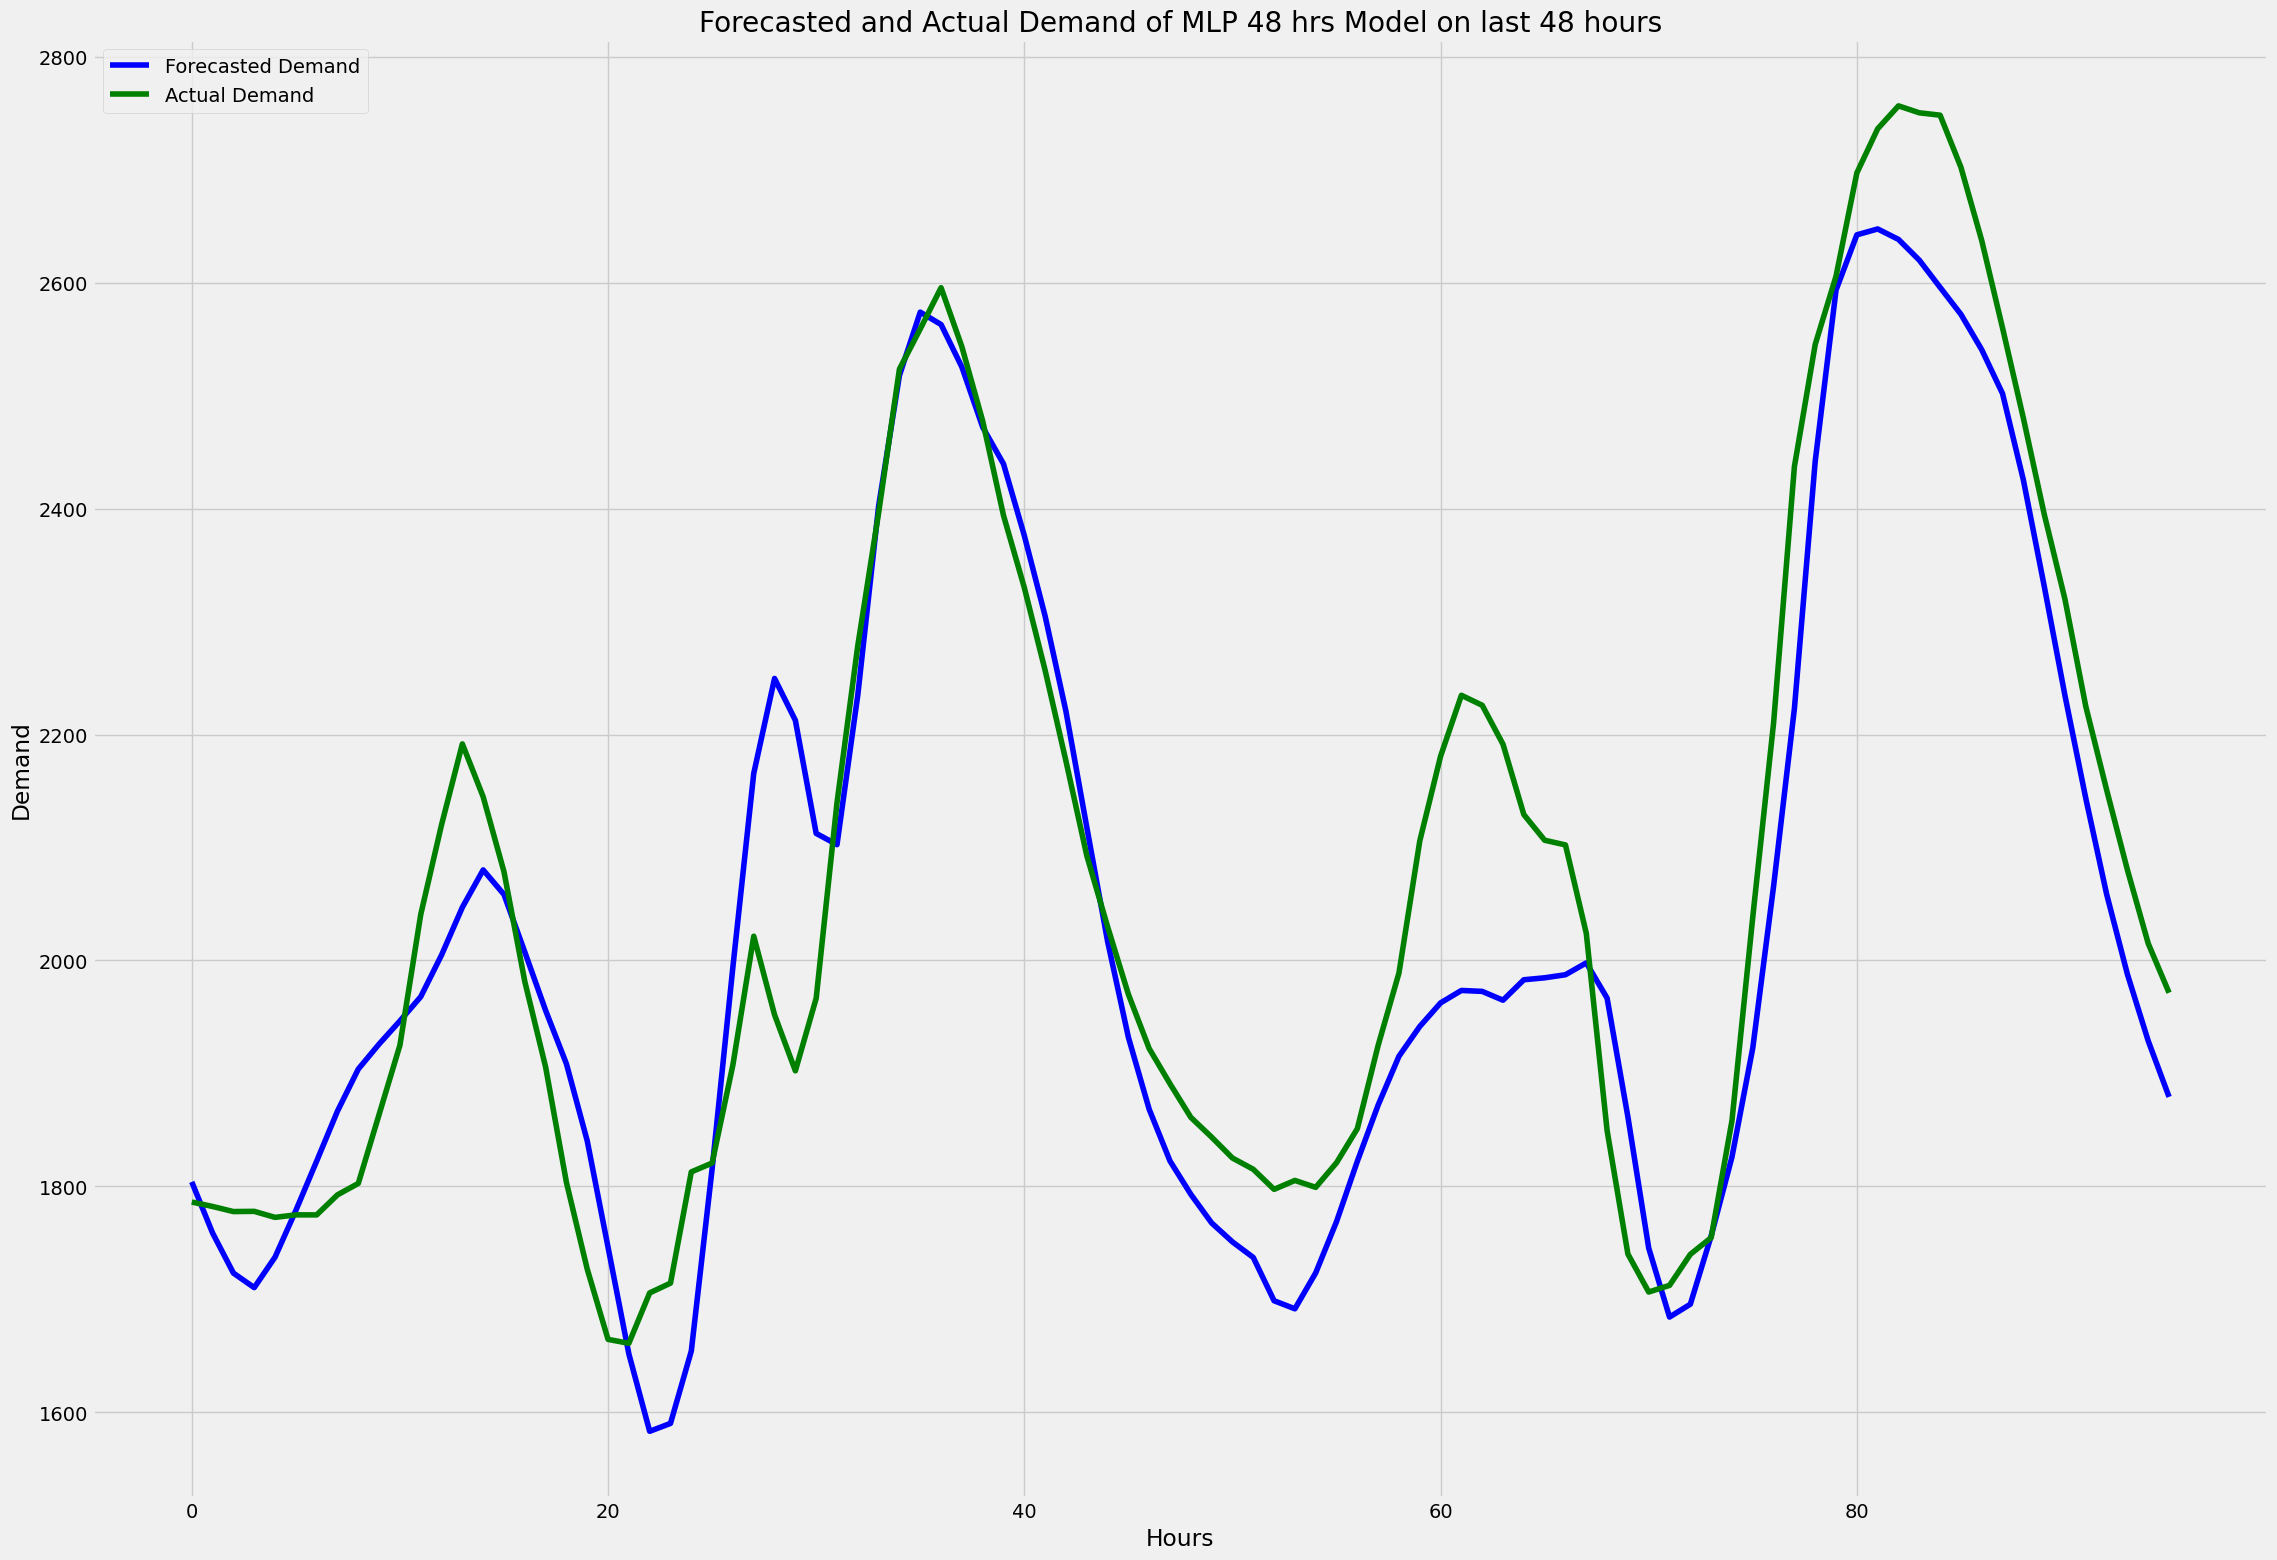

In [46]:
plot_result(final_result["Prediction"][-96:], final_result["Actual"][-96:], 'MLP 48 hrs Model on last 48 hours')

# CNN model (96 in 96 out)

In [47]:
rn.seed(24)
tf.random.set_seed(24)
n_in, n_out = 96, 96
X_train, X_test, y_train, y_test = split_data_fcast(X,y)


In [48]:
X_train.shape

(85009, 96, 53)

In [49]:
#y_test

In [50]:
n_features = 53
# define model
CNN_model = Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_in,
n_features)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(800, activation='relu'))
CNN_model.add(Dense(n_out))
CNN_model.compile(optimizer='adam', loss='mse')
# fit model
CNN_model.fit(X_train, y_train, epochs=500, verbose=1)

Epoch 1/500
2657/2657 [==============================] - 45s 16ms/step - loss: 64582.5703
Epoch 2/500
2657/2657 [==============================] - 42s 16ms/step - loss: 48196.8398
Epoch 3/500
2657/2657 [==============================] - 42s 16ms/step - loss: 45165.6758
Epoch 4/500
2657/2657 [==============================] - 42s 16ms/step - loss: 42765.9609
Epoch 5/500
2657/2657 [==============================] - 42s 16ms/step - loss: 41279.9766
Epoch 6/500
2657/2657 [==============================] - 42s 16ms/step - loss: 40056.9297
Epoch 7/500
2657/2657 [==============================] - 42s 16ms/step - loss: 39023.0352
Epoch 8/500
2657/2657 [==============================] - 42s 16ms/step - loss: 37963.6367
Epoch 9/500
2657/2657 [==============================] - 42s 16ms/step - loss: 37191.4141
Epoch 10/500
2657/2657 [==============================] - 42s 16ms/step - loss: 36630.0469
Epoch 11/500
2657/2657 [==============================] - 42s 16ms/step - loss: 35913.2227
Epoch 12

2657/2657 [==============================] - 67s 25ms/step - loss: 27629.5703
Epoch 93/500
2657/2657 [==============================] - 74s 28ms/step - loss: 27640.2070
Epoch 94/500
2657/2657 [==============================] - 69s 26ms/step - loss: 27445.5820
Epoch 95/500
2657/2657 [==============================] - 70s 26ms/step - loss: 27658.3477
Epoch 96/500
2657/2657 [==============================] - 71s 27ms/step - loss: 27422.0098
Epoch 97/500
2657/2657 [==============================] - 71s 27ms/step - loss: 27485.7891
Epoch 98/500
2657/2657 [==============================] - 70s 26ms/step - loss: 27322.2637
Epoch 99/500
2657/2657 [==============================] - 71s 27ms/step - loss: 27366.1953
Epoch 100/500
2657/2657 [==============================] - 70s 26ms/step - loss: 27441.2109
Epoch 101/500
2657/2657 [==============================] - 65s 24ms/step - loss: 27404.9219
Epoch 102/500
2657/2657 [==============================] - 71s 27ms/step - loss: 27211.8242
Epoch 103

2657/2657 [==============================] - 61s 23ms/step - loss: 24675.4629
Epoch 271/500
2657/2657 [==============================] - 64s 24ms/step - loss: 24749.0000
Epoch 272/500
2657/2657 [==============================] - 61s 23ms/step - loss: 24574.8281
Epoch 273/500
2657/2657 [==============================] - 62s 23ms/step - loss: 24869.7266
Epoch 274/500
2657/2657 [==============================] - 61s 23ms/step - loss: 24841.4414
Epoch 275/500
2657/2657 [==============================] - 60s 22ms/step - loss: 24647.9590
Epoch 276/500
2657/2657 [==============================] - 59s 22ms/step - loss: 24612.0625
Epoch 277/500
2657/2657 [==============================] - 60s 22ms/step - loss: 24631.7578
Epoch 278/500
2657/2657 [==============================] - 60s 23ms/step - loss: 24772.9102
Epoch 279/500
2657/2657 [==============================] - 61s 23ms/step - loss: 24666.7773
Epoch 280/500
2657/2657 [==============================] - 61s 23ms/step - loss: 24551.7422
Ep

2657/2657 [==============================] - 64s 24ms/step - loss: 23875.2715
Epoch 449/500
2657/2657 [==============================] - 65s 24ms/step - loss: 23781.6445
Epoch 450/500
2657/2657 [==============================] - 65s 24ms/step - loss: 23800.2734
Epoch 451/500
2657/2657 [==============================] - 65s 24ms/step - loss: 23677.9570
Epoch 452/500
2657/2657 [==============================] - 65s 24ms/step - loss: 23812.1699
Epoch 453/500
2657/2657 [==============================] - 65s 24ms/step - loss: 23608.6836
Epoch 454/500
2657/2657 [==============================] - 65s 24ms/step - loss: 23713.6992
Epoch 455/500
2657/2657 [==============================] - 66s 25ms/step - loss: 23727.7578
Epoch 456/500
2657/2657 [==============================] - 65s 25ms/step - loss: 23735.7422
Epoch 457/500
2657/2657 [==============================] - 65s 25ms/step - loss: 23790.4531
Epoch 458/500
2657/2657 [==============================] - 66s 25ms/step - loss: 23771.7520
Ep

In [51]:
final_result=make_final_df(CNN_model,96)

In [52]:
final_result['date'] = pd.date_range(start='2021-12-01', periods=len(final_result), freq='30min')
final_result

,Prediction,Actual,date
0,1845.038086,1788.716,2021-12-01 00:00:00
96,1822.592896,1768.478,2021-12-01 00:30:00
192,1768.233032,1756.662,2021-12-01 01:00:00
288,1719.930054,1735.248,2021-12-01 01:30:00
384,1736.171753,1724.418,2021-12-01 02:00:00
...,...,...,...
547968,2122.297607,2224.832,2022-03-29 22:00:00
548064,2075.501709,2151.080,2022-03-29 22:30:00
548160,2009.944214,2080.150,2022-03-29 23:00:00
548256,1979.652466,2015.012,2022-03-29 23:30:00


In [53]:
metricf(final_result["Prediction"], final_result["Actual"])

MAE : 82.693733
MSE : 12230.618650
RMSE : 110.592127
MAPE : 0.038996


In [54]:
df_merged=metric_for_peak_days(threshold)
df_merged[df_merged["Prediction"].gt(threshold)]

,Date,Prediction,Actual
26,2021-12-27,134720.609375,139702.954
49,2022-01-19,139009.359375,143929.714
50,2022-01-20,137994.671875,139644.016
51,2022-01-21,138917.437500,141839.600
65,2022-02-04,137782.953125,142620.646
77,2022-02-16,141176.140625,143068.538


In [55]:
confusion_matrix_cal(threshold)

Confusion Matrix : 
 [[110   0]
 [  4   6]]
Accuracy :  0.9666666666666667
Sensitivity :  1.0
Specificity :  0.6


Accuracy: 0.8268722325630921


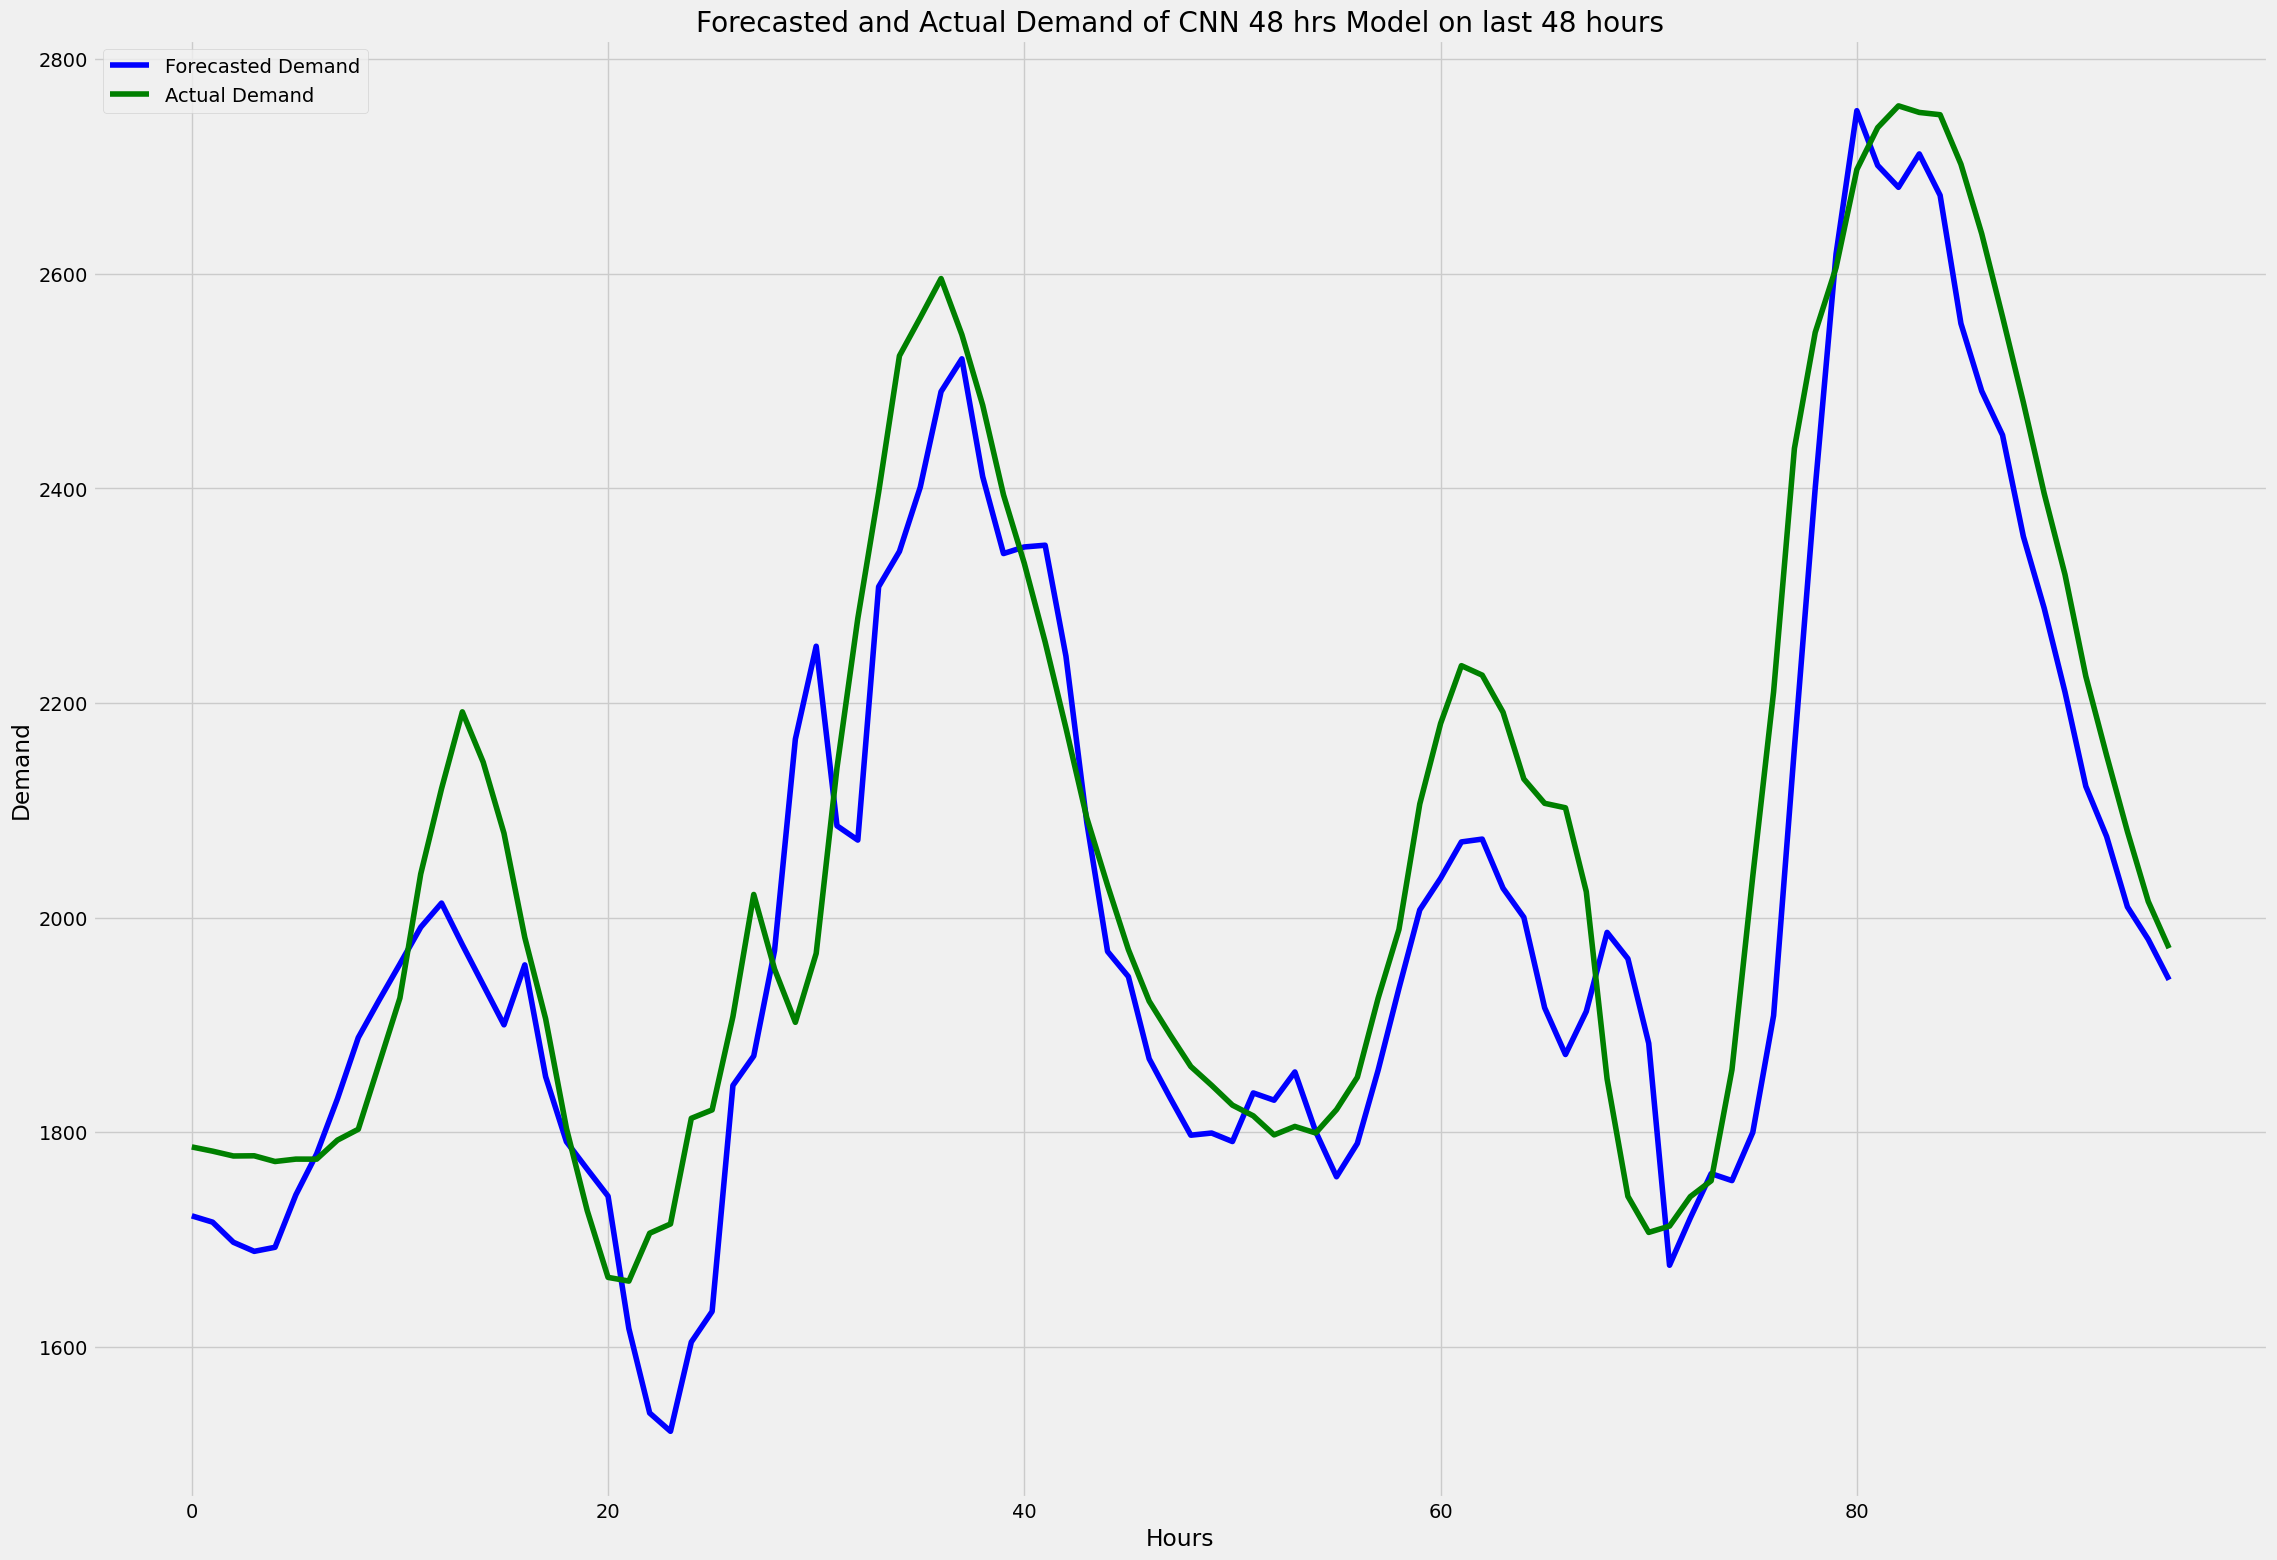

In [205]:
plot_result(final_result["Prediction"][-96:], final_result["Actual"][-96:], 'CNN 48 hrs Model on last 48 hours')

## SHAP Values

In [ ]:
#import shap
#import numpy as np

# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(CNN_model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:10])

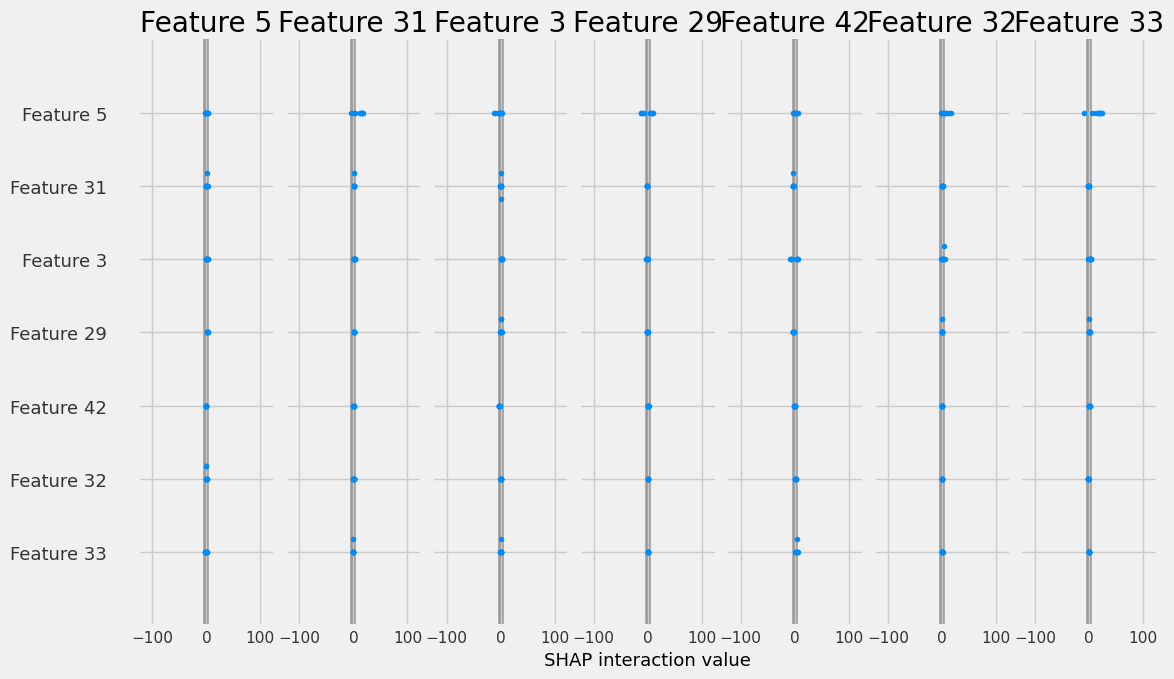

In [159]:
shap.summary_plot(shap_values[0])